<a href="https://colab.research.google.com/github/SEKAR147/IJCAI_Work/blob/main/Graph_Prompts_Adapting_Video_Graph_for_Video_Question_Answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision transformers
!pip install opencv-python matplotlib


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np


In [ ]:
img = cv2.imread("/content/xray image.jpg", 0)
img = cv2.resize(img, (224,224))
img = torch.tensor(img).float().unsqueeze(0).unsqueeze(0) / 255.0
img = img.cuda()


In [ ]:
class SimpleSeg(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 1, 3, padding=1)

    def forward(self, x):
        return torch.sigmoid(self.conv(x))


In [ ]:
class SimpleSeg(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 1, 3, padding=1)

    def forward(self, x):
        return torch.sigmoid(self.conv(x))


In [ ]:
seg_model = SimpleSeg().cuda()
mask = seg_model(img)


In [ ]:
seg_token_embedding = mask.mean().unsqueeze(0)


In [ ]:
class SimpleVQA(nn.Module):
    def __init__(self):
        super().__init__()
        self.img_fc = nn.Linear(1, 128)
        self.txt_fc = nn.Linear(10, 128)
        self.cls = nn.Linear(128, 2)  # Yes / No

    def forward(self, seg_feat, q_feat):
        x = self.img_fc(seg_feat) + self.txt_fc(q_feat)
        return self.cls(x)


In [ ]:
question_feat = torch.randn(1,10).cuda()  # dummy question vector


In [ ]:
model = SimpleVQA().cuda()

seg_feat = seg_token_embedding.unsqueeze(1)
logits = model(seg_feat, question_feat)


In [ ]:
label = torch.tensor([1]).cuda()  # Yes
loss = nn.CrossEntropyLoss()(logits, label)
loss.backward()


In [ ]:
highlighted_img = img * mask


In [ ]:
mask2 = seg_model(highlighted_img)
seg_feat2 = mask2.mean().unsqueeze(0).unsqueeze(1)

logits_refined = model(seg_feat2, question_feat)


In [ ]:
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(seg_model.parameters()),
    lr=1e-3
)


In [ ]:
epochs = 10

for epoch in range(epochs):
    optimizer.zero_grad()

    # ---- Forward ----
    mask = seg_model(img)
    seg_feat = mask.mean().unsqueeze(0).unsqueeze(1)

    logits = model(seg_feat, question_feat)

    # ---- Loss ----
    loss = nn.CrossEntropyLoss()(logits, label)

    # ---- Backward ----
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}")


Epoch 1/10 | Loss: 0.6970
Epoch 2/10 | Loss: 0.5678
Epoch 3/10 | Loss: 0.4580
Epoch 4/10 | Loss: 0.3666
Epoch 5/10 | Loss: 0.2921
Epoch 6/10 | Loss: 0.2322
Epoch 7/10 | Loss: 0.1848
Epoch 8/10 | Loss: 0.1475
Epoch 9/10 | Loss: 0.1183
Epoch 10/10 | Loss: 0.0955


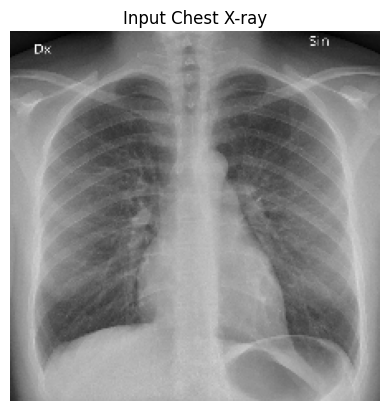

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img[0][0].cpu(), cmap="gray")
plt.title("Input Chest X-ray")
plt.axis("off")
plt.show()


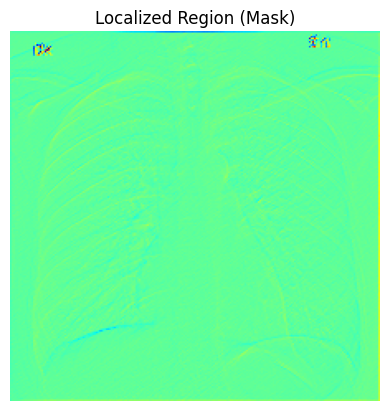

In [ ]:
plt.imshow(mask[0][0].detach().cpu(), cmap="jet")
plt.title("Localized Region (Mask)")
plt.axis("off")
plt.show()


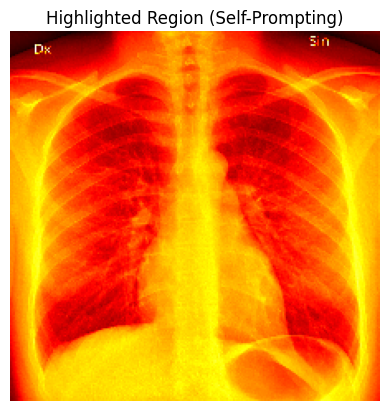

In [ ]:
overlay = img[0][0].cpu() + 0.5 * mask[0][0].detach().cpu()

plt.imshow(overlay, cmap="hot")
plt.title("Highlighted Region (Self-Prompting)")
plt.axis("off")
plt.show()


In [ ]:
pred = torch.argmax(logits_refined, dim=1).item()

answer_map = {0: "No abnormality", 1: "Abnormality present"}
print("Predicted Answer:", answer_map[pred])


Predicted Answer: No abnormality
